# House Prices: Advanced Regression Techniques

In this notebook I detail my process working through the Ames Housing dataset.

Data for and information on this Kaggle competition can be found at:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## Imports

In [236]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from scipy.cluster import hierarchy as hc
from scipy.special import boxcox1p
from scipy.stats import norm, skew
from scipy import stats
from fastai.structured import *

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from mlxtend.regressor import StackingCVRegressor
import xgboost as xgb
import lightgbm as lgb

## Data Loading

In [2]:
PATH = "data/house_prices/"

Begin by reading in the data as a pandas dataframe, and having a look at the data types we are working with.

In [3]:
train_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)
test_raw = pd.read_csv(f'{PATH}test.csv', low_memory=False)

In [4]:
train_raw

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


There are 1460 training examples each with 81 features. It would be convenient to view these features by displaying the transpose of the dataframe. We create a function to display an un-truncated view.

In [5]:
 def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [6]:
display_all(train_raw.head().T)

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84
LotArea,8450,9600,11250,9550,14260
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


In [7]:
display_all(test_raw.head().T)

,0,1,2,3,4
Id,1461,1462,1463,1464,1465
MSSubClass,20,20,60,60,120
MSZoning,RH,RL,RL,RL,RL
LotFrontage,80,81,74,78,43
LotArea,11622,14267,13830,9978,5005
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,IR1,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl,HLS
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


In [8]:
train_raw.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [9]:
test_raw.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


Upon initial inspection, it appears that the test set is a random sample. Similar means of YearBuilt and YrSold between the train and test set indicate this. It is important to know whether the test set is a random sample or not, as this will dictate how we construct our validation set. We will confirm this later before constructing our validation set.

## Outlier Removal

Information on the data set indicated the presence of outliers, we will visualize these by plotting each numerical variable against SalePrice.

In [10]:
# for col in train_raw.select_dtypes([np.number]).columns:
#     fig, ax = plt.subplots()
#     ax.scatter(x = train_raw[col], y = train_raw['SalePrice'],c="purple", s=2.5)
#     plt.ylabel('SalePrice', fontsize=12)
#     plt.xlabel(col, fontsize=12)
#     plt.show()
    

LotFrontage, LotArea and GrLivArea appear to have significant outliers. We will inspect these features more closely.

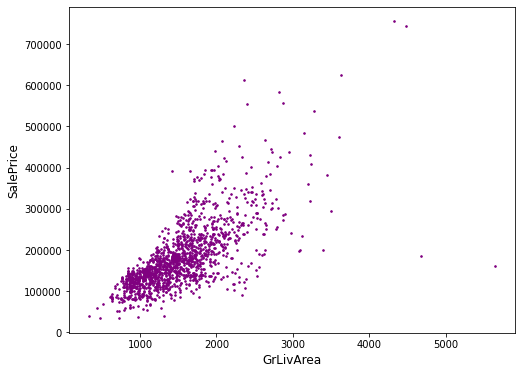

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x = train_raw['GrLivArea'], y = train_raw['SalePrice'],c="purple", s=2.5)
plt.ylabel('SalePrice', fontsize=12)
plt.xlabel('GrLivArea', fontsize=12)
plt.show()

We will remove the 2 outlier points on the bottom right.

In [12]:
train_raw = train_raw.drop(train_raw[(train_raw['GrLivArea']>4000) & (train_raw['SalePrice']<400000)].index)

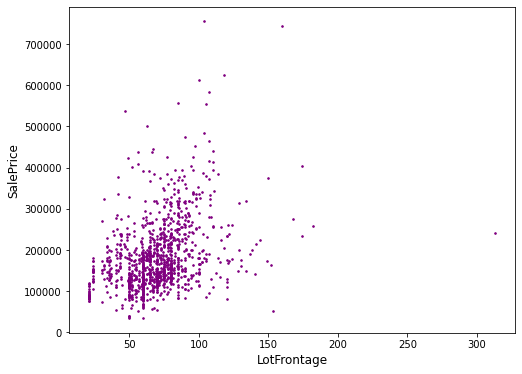

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x = train_raw['LotFrontage'], y = train_raw['SalePrice'],c="purple", s=2.5)
plt.ylabel('SalePrice', fontsize=12)
plt.xlabel('LotFrontage', fontsize=12)
plt.show()

We will remove the 1 outlier on the right.

In [14]:
train_raw = train_raw.drop(train_raw[(train_raw['LotFrontage']>300) & (train_raw['SalePrice']<400000)].index)

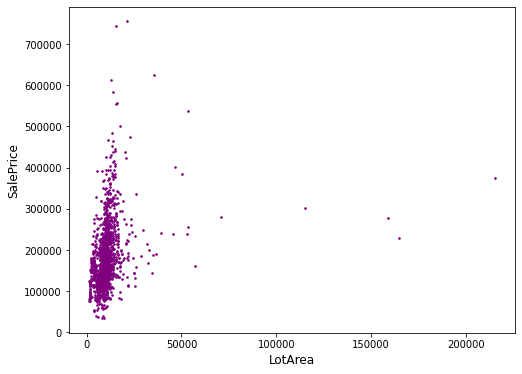

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x = train_raw['LotArea'], y = train_raw['SalePrice'],c="purple", s=2.5)
plt.ylabel('SalePrice', fontsize=12)
plt.xlabel('LotArea', fontsize=12)
plt.show()

We will remove the 4 outliers on the right.

In [16]:
train_raw = train_raw.drop(train_raw[(train_raw['LotArea']>100000) & (train_raw['SalePrice']<400000)].index)

## Dependent Variable

The objective of this model is to predict SalePrice. We will split off this variable and analyse its distribution. 

In [17]:
labels = train_raw["SalePrice"].copy()
labels.describe()

count      1453.000000
mean     180574.842395
std       79338.212690
min       34900.000000
25%      129900.000000
50%      162900.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

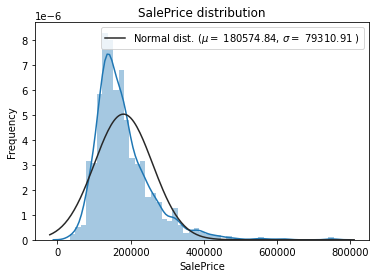

In [18]:
fig, ax1 = plt.subplots()
sns.distplot(labels, ax=ax1, fit=stats.norm)
(mu, sigma) = stats.norm.fit(labels)
plt.legend(['Normal dist. ($\mu=$ {:.2f}, $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution');

The SalePrice distribution is right skewed. Our model will fit better to normally distributed data. We will transform the data by applying log(1+x) to all elements

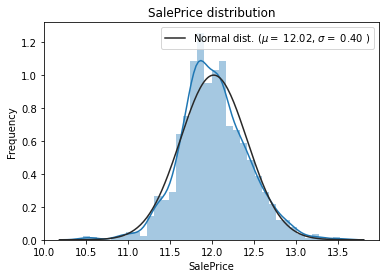

In [19]:
labels = np.log1p(labels)

fig, ax1 = plt.subplots()
sns.distplot(labels, ax=ax1, fit=stats.norm)
(mu, sigma) = stats.norm.fit(labels)
plt.legend(['Normal dist. ($\mu=$ {:.2f}, $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution');

## Missing Values

It is apparent that there may be  missing values in our data. To visualise the extent of these missing values we will use missingno.

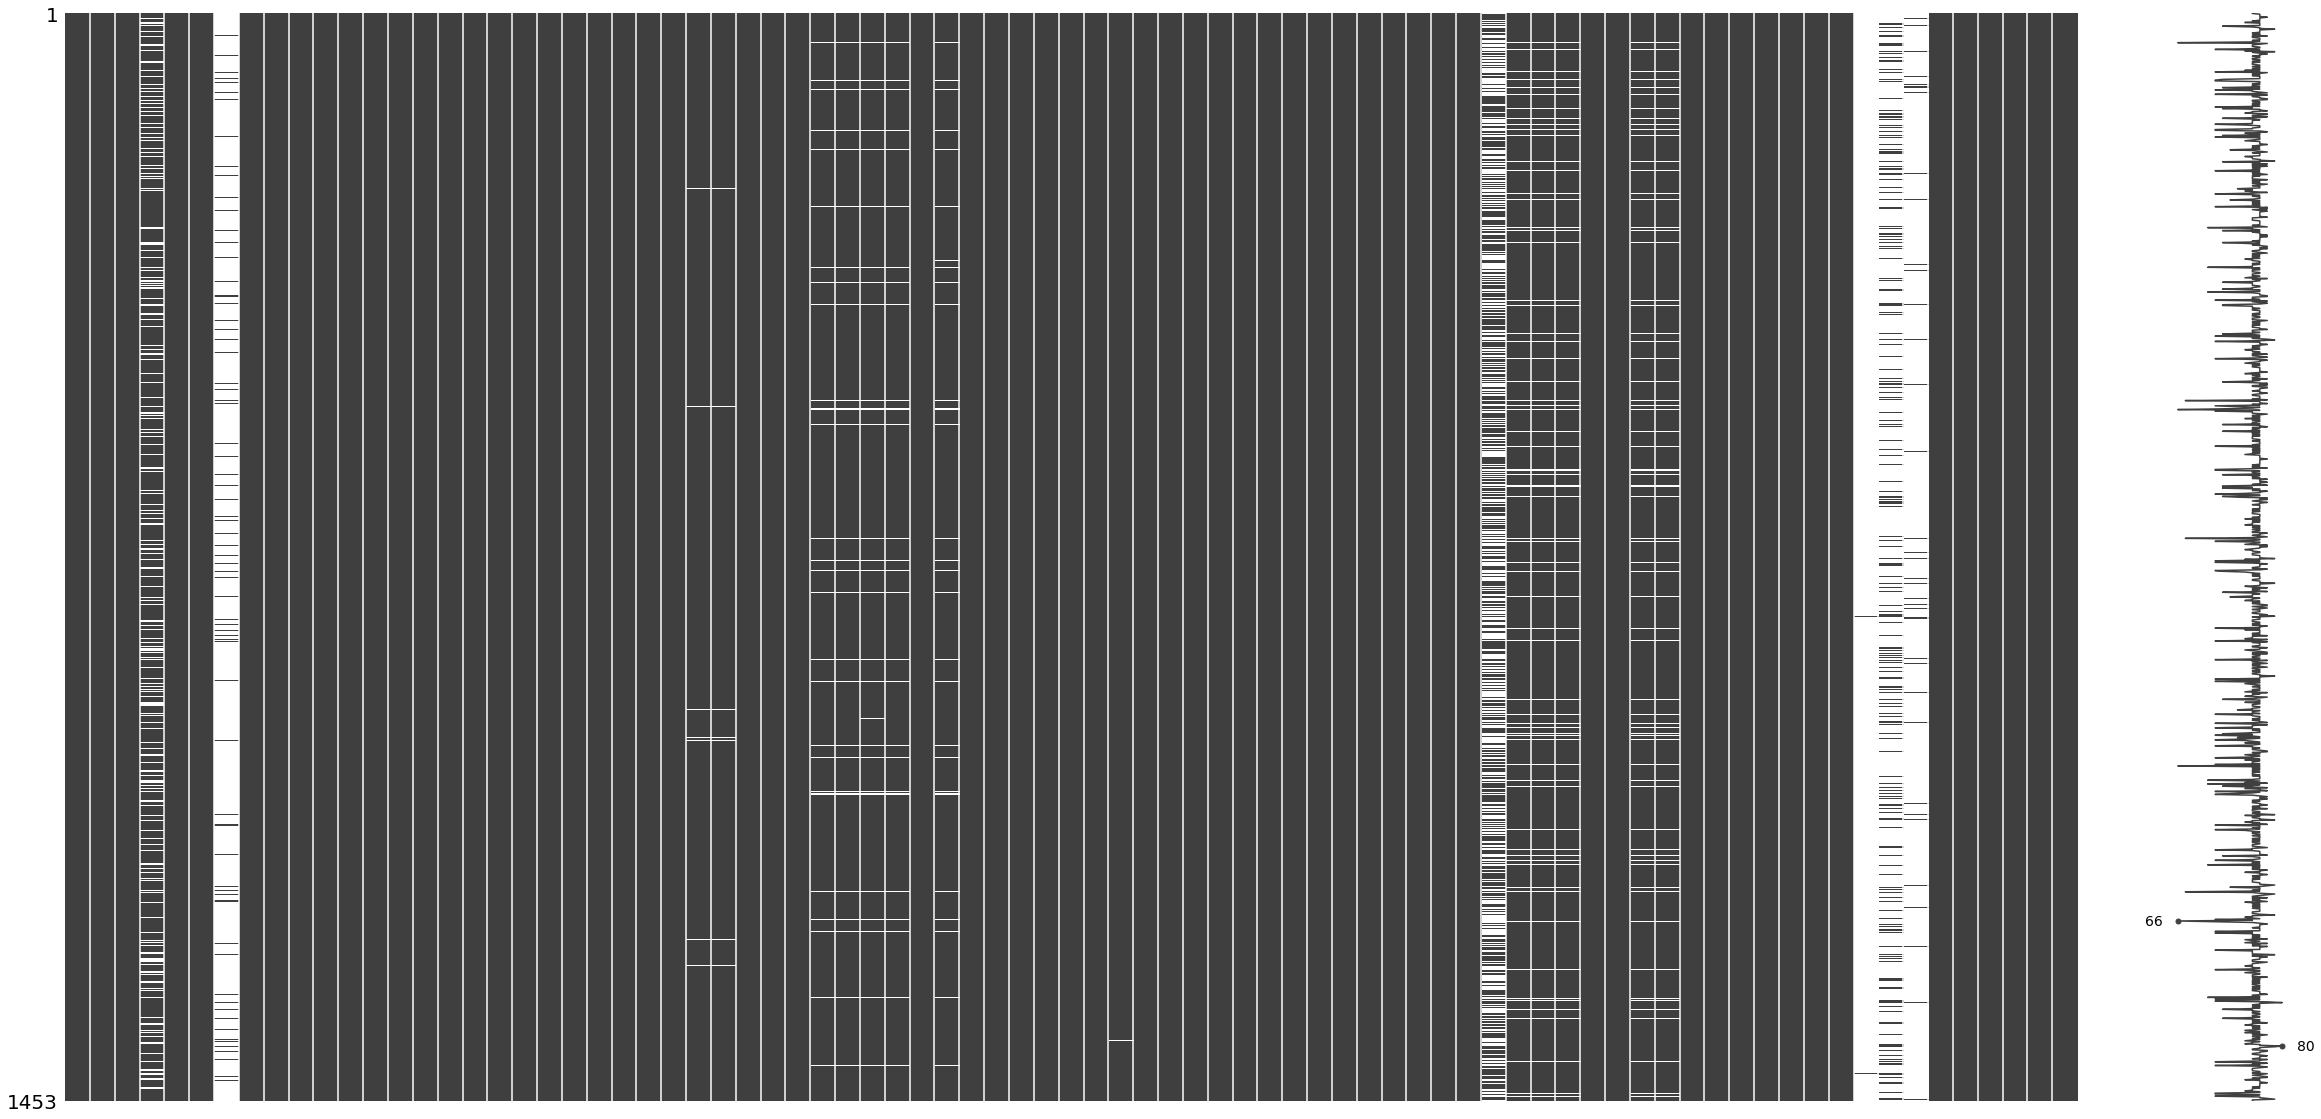

In [20]:
missingno.matrix(train_raw, figsize=(40,20));

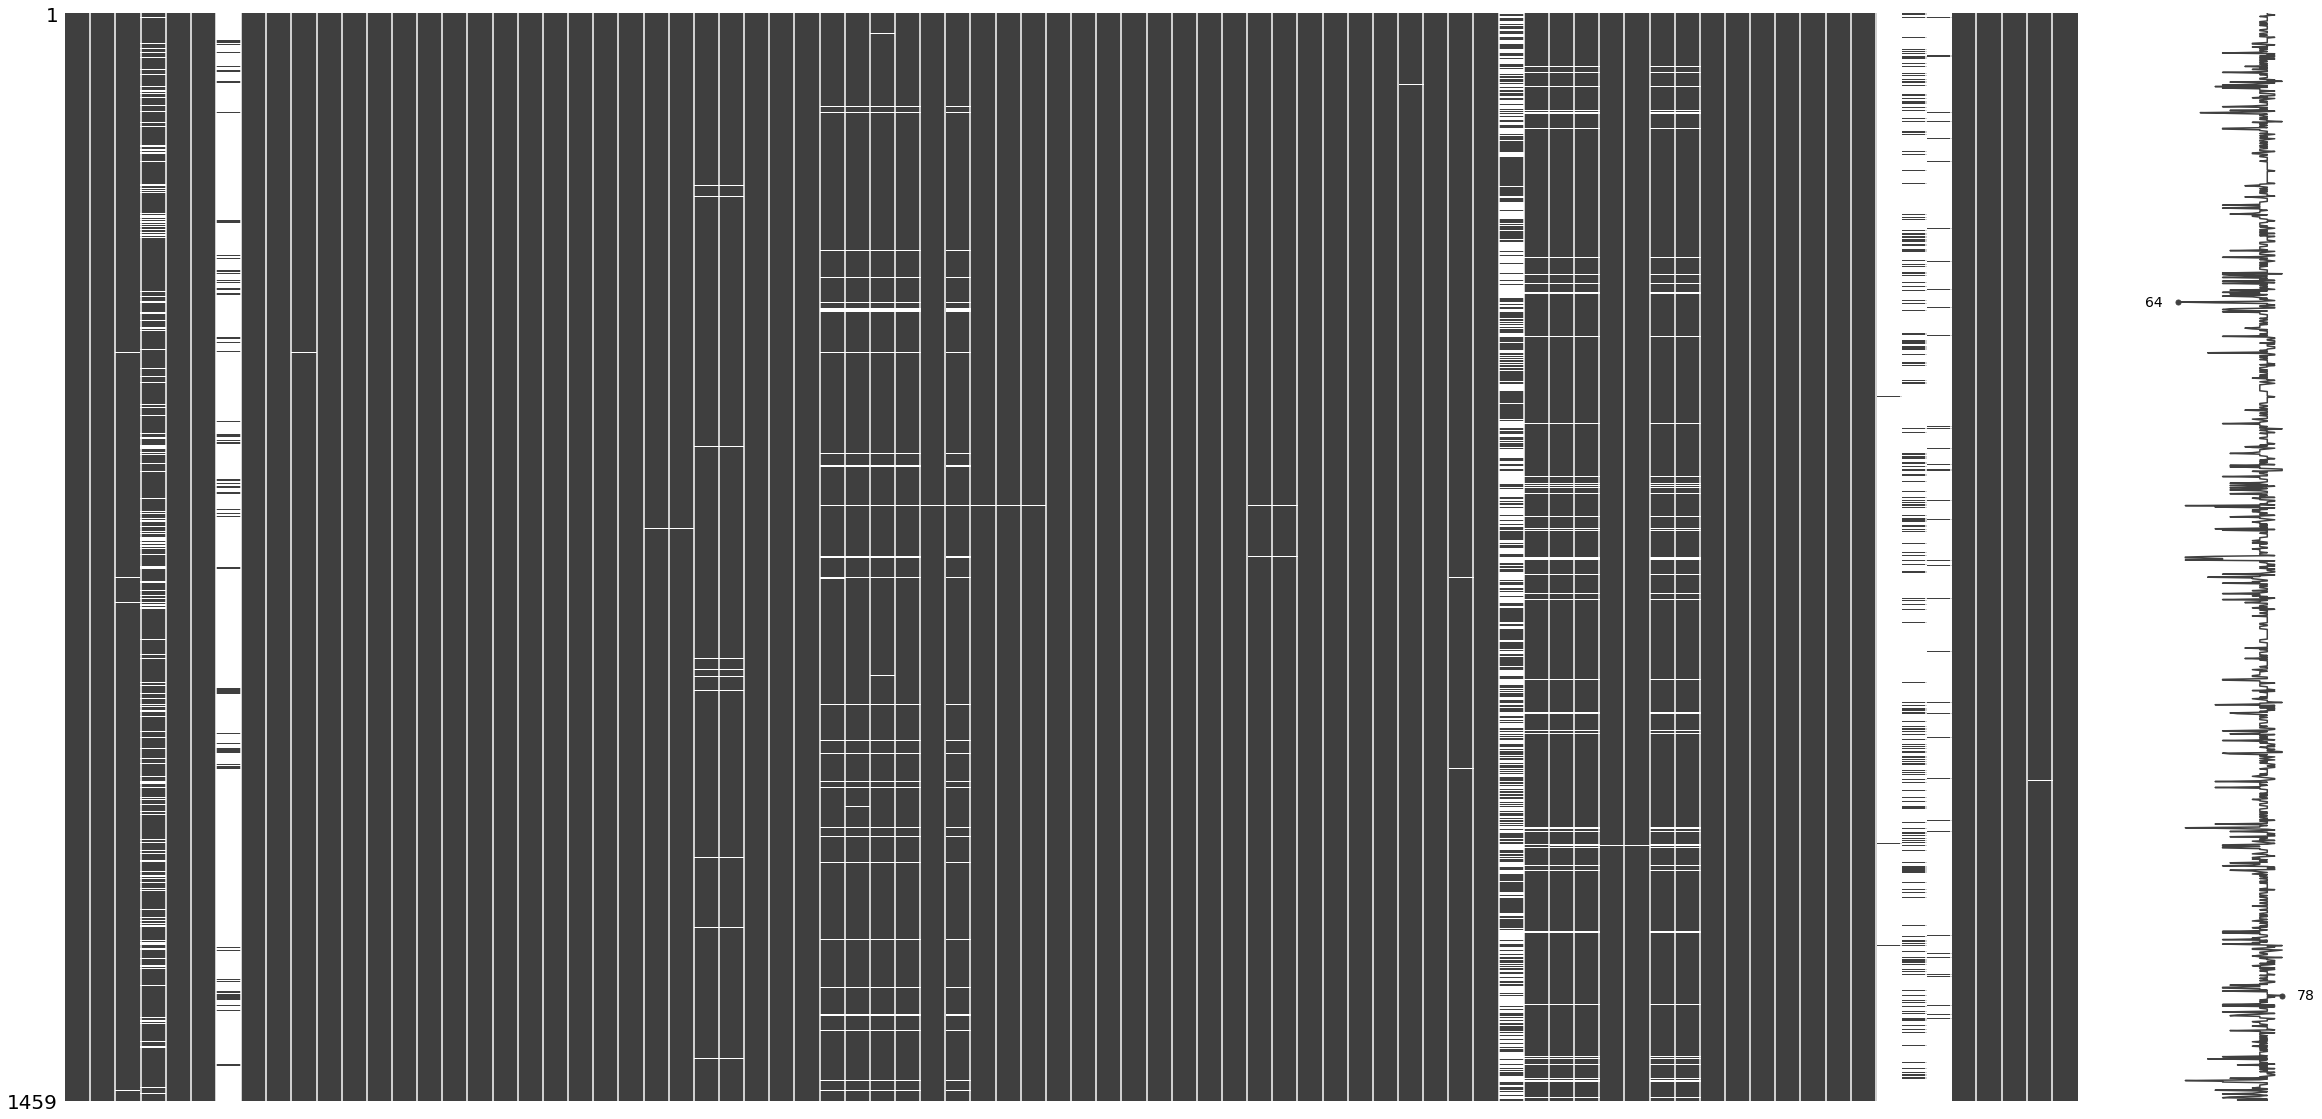

In [21]:
missingno.matrix(test_raw, figsize=(40,20));

The columns represent the different features of the data, while the white spaces indicate a missing value for that feature for a particular example (row). We have confirmed that there are indeed many missing values in the data. We will now quantify this by displaying the percentage of missing values for each feature.

In [22]:
print("Train data:\n")
print("Feature      % missing")
display_all(round(train_raw.isnull().mean()*100,2).sort_values(ascending=False)) 

Train data:

Feature      % missing


PoolQC           99.59
MiscFeature      96.42
Alley            93.74
Fence            80.66
FireplaceQu      47.49
LotFrontage      17.62
GarageCond        5.57
GarageType        5.57
GarageYrBlt       5.57
GarageFinish      5.57
GarageQual        5.57
BsmtExposure      2.62
BsmtFinType2      2.62
BsmtFinType1      2.55
BsmtCond          2.55
BsmtQual          2.55
MasVnrArea        0.55
MasVnrType        0.55
Electrical        0.07
Utilities         0.00
YearRemodAdd      0.00
MSSubClass        0.00
Foundation        0.00
ExterCond         0.00
ExterQual         0.00
Exterior2nd       0.00
Exterior1st       0.00
RoofMatl          0.00
RoofStyle         0.00
YearBuilt         0.00
LotConfig         0.00
OverallCond       0.00
OverallQual       0.00
HouseStyle        0.00
BldgType          0.00
Condition2        0.00
BsmtFinSF1        0.00
MSZoning          0.00
LotArea           0.00
Street            0.00
Condition1        0.00
Neighborhood      0.00
LotShape          0.00
LandContour

In [23]:
print("Test data:\n")
print("Feature      % missing")
display_all(round(test_raw.isnull().mean()*100,2).sort_values(ascending=False)) 

Test data:

Feature      % missing


PoolQC           99.79
MiscFeature      96.50
Alley            92.67
Fence            80.12
FireplaceQu      50.03
LotFrontage      15.56
GarageCond        5.35
GarageQual        5.35
GarageYrBlt       5.35
GarageFinish      5.35
GarageType        5.21
BsmtCond          3.08
BsmtQual          3.02
BsmtExposure      3.02
BsmtFinType1      2.88
BsmtFinType2      2.88
MasVnrType        1.10
MasVnrArea        1.03
MSZoning          0.27
BsmtHalfBath      0.14
Utilities         0.14
Functional        0.14
BsmtFullBath      0.14
BsmtFinSF2        0.07
BsmtFinSF1        0.07
Exterior2nd       0.07
BsmtUnfSF         0.07
TotalBsmtSF       0.07
SaleType          0.07
Exterior1st       0.07
KitchenQual       0.07
GarageArea        0.07
GarageCars        0.07
HouseStyle        0.00
LandSlope         0.00
MSSubClass        0.00
LotArea           0.00
Street            0.00
LotShape          0.00
LandContour       0.00
LotConfig         0.00
Neighborhood      0.00
BldgType          0.00
Condition1 

After reading the descriptions provided with the data, it appears that most of these missing values indicate the absence of a particular feature, and few of these missing values represent actual missing data. 

To address the missing values in the data, we will combine train and test into a single dataframe and then iterate over each feature to find an appropriate value to put in place.

In [24]:
data = pd.concat([train_raw, test_raw])
data.drop(['SalePrice'], axis=1, inplace=True)

The data descriptions for PoolQC, MiscFeature, Alley, Fence and FireplaceQu indicate that Na represents the absence of this feature. We can set these missing values to "None".

In [25]:
for feat in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
    data[feat] = data[feat].fillna('None')

We will assume that missing values for GarageType, GarageFinish, GarageQual and GarageCond means the property has no garage and that missing values for BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 means no basement. We will set these missing values to "None".

In [26]:
for feat in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    data[feat] = data[feat].fillna('None')

We will assume that missing values for GarageYrBlt, GarageArea and GarageCars means the property has no garage and that missing values for BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath means no basement. As these are continuous variables we will set these to 0.

In [27]:
for feat in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
             'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath' ]:
    data[feat] = data[feat].fillna(0)

LotFrontage : The data description reads that this is Linear feet of street connected to the property. We will assume this value is similar to other houses in the same neighbourhood; we will fill this value with the median neighbourhood value.

In [28]:
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

MasVnrArea and MasVnrType : Assume missing values means no masonry veneer.

In [29]:
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

MSZoning, Electrical, KitchenQual, SaleType, Exterior1st, Exterior2nd and Utilities: Replace missing values by the most common code.

In [30]:
data['MSZoning'] = data['MSZoning'].fillna("RL")
data['Utilities'] = data['Utilities'].fillna("AllPub")
data['Electrical'] = data['Electrical'].fillna("SBrkr")
data['KitchenQual'] = data['KitchenQual'].fillna("SBrkr")
data['SaleType'] = data['SaleType'].fillna("WD")
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])

Functional: The data description reads that NA means "Typ".

In [31]:
data["Functional"] = data["Functional"].fillna("Typ")

MSSubClass: Assume missing values means no building class.

In [32]:
data['MSSubClass'] = data['MSSubClass'].fillna("None")

In [33]:
print("All Data:\n")
print("Feature    % missing")
display_all(round(data.isnull().mean()*100,2).sort_values(ascending=False)) 

All Data:

Feature    % missing


SaleCondition    0.0
SaleType         0.0
RoofStyle        0.0
RoofMatl         0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
MasVnrArea       0.0
ExterQual        0.0
ExterCond        0.0
Foundation       0.0
BsmtQual         0.0
BsmtCond         0.0
BsmtExposure     0.0
BsmtFinType1     0.0
BsmtFinSF1       0.0
BsmtFinType2     0.0
BsmtFinSF2       0.0
BsmtUnfSF        0.0
YearRemodAdd     0.0
YearBuilt        0.0
OverallCond      0.0
LandContour      0.0
MSSubClass       0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
Street           0.0
Alley            0.0
LotShape         0.0
Utilities        0.0
OverallQual      0.0
LotConfig        0.0
LandSlope        0.0
Neighborhood     0.0
Condition1       0.0
Condition2       0.0
BldgType         0.0
HouseStyle       0.0
TotalBsmtSF      0.0
Heating          0.0
HeatingQC        0.0
3SsnPorch        0.0
GarageArea       0.0
GarageQual       0.0
GarageCond       0.0
PavedDrive       0.0
WoodDeckSF   

## Feature Engineering

Some categorical variables are presented as numerical variables. We convert these values to text.

In [34]:
data['MSSubClass'] = data['MSSubClass'].apply(str)
data['OverallCond'] = data['OverallCond'].astype(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

We create two new variables, TotalPorchSF and TotalSF and remove the Id variable as it likely has no correlation to SalePrice.

In [35]:
data['TotalPorchSF'] = (data['OpenPorchSF'] + data['3SsnPorch'] +
                        data['EnclosedPorch'] + data['ScreenPorch'] +
                        data['WoodDeckSF'])

data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

data = data.drop(['Id'], axis=1)

We now label encode our ordered categorical variables.

In [36]:
cats = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 
           'GarageQual', 'GarageCond', 'GarageFinish', 'GarageType', 
           'FireplaceQu', 'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 
           'Functional', 'Fence', 'LandSlope', 'LotShape', 'PavedDrive', 'Alley', 'CentralAir', 
           'MSSubClass', 'OverallCond', 'GarageCars', 'YrSold', 'MoSold', 'Fireplaces', 'HalfBath']

for c in cats:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))

For the same reason we transformed the distribution of the dependent variable, we normalise the distribution of the independent variables.

In [37]:
numeric_features = data.dtypes[data.dtypes != "object"].index
skewed_features = data[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
skew = pd.DataFrame({'Skew' :skewed_features})
skew.head(10)

,Skew
MiscVal,21.944005
PoolArea,17.673354
LowQualFinSF,12.073977
3SsnPorch,11.362112
LandSlope,4.976698
KitchenAbvGr,4.296287
BsmtFinSF2,4.158442
EnclosedPorch,3.998474
ScreenPorch,3.941117
BsmtHalfBath,3.940486


In [38]:
high_skew = skew[skew > 0.5]
skew_index = high_skew.index

for i in skew_index:
    data[i] += 1
    data[i] = boxcox1p(data[i], stats.boxcox_normmax(data[i] + 1))
    
data[skew_index] = np.log1p(data[skew_index])

data = pd.get_dummies(data)

In [39]:
data.head().T

,0,1,2,3,4
MSSubClass,2.330937,1.839105,2.330937,2.403721,2.330937
LotFrontage,3.269795,3.412402,3.300741,3.214961,3.445978
LotArea,3.550648,3.584931,3.627420,3.583530,3.690688
Alley,1.163990,1.163990,1.163990,1.163990,1.163990
LotShape,1.352628,1.352628,0.630673,0.630673,0.630673
...,...,...,...,...,...
SaleCondition_AdjLand,0.000000,0.000000,0.000000,0.000000,0.000000
SaleCondition_Alloca,0.000000,0.000000,0.000000,0.000000,0.000000
SaleCondition_Family,0.000000,0.000000,0.000000,0.000000,0.000000
SaleCondition_Normal,1.000000,1.000000,1.000000,0.000000,1.000000


## Model Prototyping

Data pre-processing is complete and we can now start prototyping models. First we must construct an appropriate validation set. To do this we must determine whether the test set is a random sample or not. If it is not a random sample, we must ensure the validation set comes from the same distribution of data as the test set.

To know if the test set was randomly sampled, we can create a model where the dependent variable is whether or not it is in the test set. We can combine the train and test set and create a new variable is_test. This will be set to 0 for examples from the train set and 1 for examples from the test set. If the test set was sampled randomly, then the model should not be able to predict is_test.

In [40]:
df = data.copy()
df["is_test"] = 1
df.is_test[:len(test_raw)] = 0
x = df.drop(["is_test"], axis=1)
y = df["is_test"].copy()

In [41]:
m = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.5013736263736264

The model is no more accurate than random guessing. This confirms that the test set is a random sample, and we can sample our validation set accordingly.

If we found that the test set was comprised of examples of a different time period, for example when predicting future house prices, then we want our validation set to consist of examples of sale dates our model hasn’t been trained on. This would simulate the test set and we can optimize the model to predict future values.

In [42]:
features = data[:len(train_raw)]
test = data[len(train_raw):]

X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.3, random_state=42)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1017, 218), (436, 218), (1017,), (436,))

We can now train some base models to compare against later models.

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted sale prices. We will therefore use this metric to score our models.

In [43]:
def rmsle(labels, predictions):
    return np.sqrt(mean_squared_error(labels, predictions))

def show_scores(model):
    scores = ['Training Error: ' + str(rmsle(model.predict(X_train), y_train)),
           'Validation Error: ' + str(rmsle(model.predict(X_valid), y_valid)),
            'Training Accuracy: ' + str(model.score(X_train, y_train)), 
           'Validation Accuracy: ' + str(model.score(X_valid, y_valid))]
    if hasattr(model, 'oob_score_'): scores.append('OOB Score: ' + str((model.oob_score_)))
    for score in scores:
        print(score)

In [44]:
RandomForest = RandomForestRegressor()
lasso = Lasso()
Elastic = ElasticNet()
KR = KernelRidge()
GBoost = GradientBoostingRegressor()
XGB = xgb.XGBRegressor()
LGBM = lgb.LGBMRegressor()

models = [RandomForest, lasso, Elastic, KR, GBoost, XGB, LGBM]

for model in models:
    model.fit(X_train, y_train)
    print(type(model).__name__)
    show_scores(model)
    print("")

RandomForestRegressor
Training Error: 0.05366289280375328
Validation Error: 0.12375523913075388
Training Accuracy: 0.9822550412015151
Validation Accuracy: 0.899031621351073

Lasso
Training Error: 0.38460223422053597
Validation Error: 0.3661332927199001
Training Accuracy: 0.08851308178655715
Validation Accuracy: 0.11623532633956324

ElasticNet
Training Error: 0.38329116788689677
Validation Error: 0.364163302319802
Training Accuracy: 0.09471680532696547
Validation Accuracy: 0.12571998226526637

KernelRidge
Training Error: 0.10177397064778408
Validation Error: 0.11174801848014376
Training Accuracy: 0.9361736114754118
Validation Accuracy: 0.9176738403471378

GradientBoostingRegressor
Training Error: 0.07451458894843684
Validation Error: 0.11070073411416093
Training Accuracy: 0.9657855585538556
Validation Accuracy: 0.9192097044507935

XGBRegressor
Training Error: 0.00740810788668308
Validation Error: 0.1243076363414629
Training Accuracy: 0.9996618250524331
Validation Accuracy: 0.89812823932

The Gradient Boosting Regressor yields the lowest validation error. We will tune this model to further increase performance.

## Model Optimisation

We first perform a randomised gird search to efficiently sample a wide range of model parameters.

In [45]:
# parameters = {
#     'loss' : ['ls', 'lad', 'huber', 'quantile'],
#     'learning_rate' : [0.25, 0.2, 0.1, 0.075, 0.05, 0.025, 0.02, 0.015, 0.01],
#     'n_estimators' : [100, 250, 500, 750, 1000, 1250, 1500, 2000, 2500, 3000, 4000],
#     'max_features' : ['auto', 'sqrt', 'log2', 0.5, 0.6, 0.8],
#     'min_samples_leaf' : [1, 2, 3, 4, 5, 6, 8 ,10, 15],
#     'min_samples_split' : [1, 2, 3, 4, 5],
#     'max_depth' : [3, 4, 5]
# }

# m = GradientBoostingRegressor()
# clf = RandomizedSearchCV(m, parameters, random_state=5, n_jobs=-1, n_iter=200)
# search = clf.fit(X_train, y_train)

After further manual tuning, the following optimised model was obtained.

In [49]:
GBoost = GradientBoostingRegressor(n_estimators=1013, learning_rate=0.0259,
                                   max_features='sqrt',
                                   min_samples_leaf=2,  
                                   loss='huber', random_state =5,
                                   max_depth=3)
GBoost.fit(X_train, y_train)
show_scores(GBoost)

Training Error: 0.07155377906529083
Validation Error: 0.10013836735791191
Training Accuracy: 0.9684505359708206
Validation Accuracy: 0.9338912100523624


## Feature Importance

Removing features can reduce the risk of overfit. Performing feature importance provides insight on how the model makes predictions.

In [79]:
fi = rf_feat_importance(GBoost, features); fi[:10]

,cols,imp
6,OverallQual,0.140066
59,TotalSF,0.104000
27,GrLivArea,0.062254
43,GarageArea,0.053031
9,YearRemodAdd,0.046033
39,GarageType,0.044235
42,GarageCars,0.037041
11,ExterQual,0.034461
21,TotalBsmtSF,0.034202
17,BsmtFinSF1,0.025921


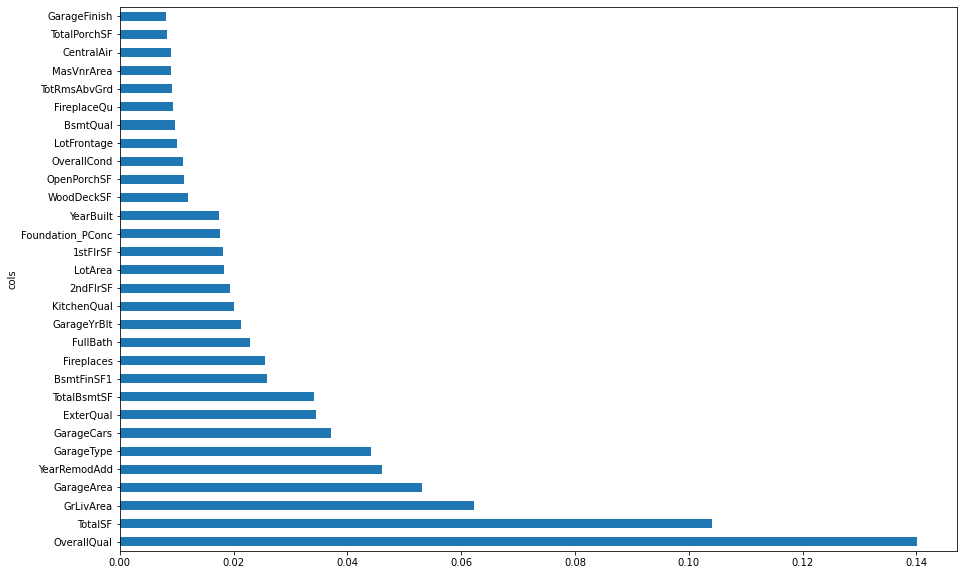

In [80]:
fi[:30].plot('cols', 'imp', 'barh', figsize=(15,10), legend=False);

In [85]:
to_keep = fi[fi.imp>0.0001].cols
len(to_keep)

116

In [86]:
X_train = X_train[to_keep]
X_valid = X_valid[to_keep]

In [87]:
GBoost3 = GradientBoostingRegressor(n_estimators=1013, learning_rate=0.0259,
                                   max_features='sqrt',
                                   min_samples_leaf=2,  
                                   loss='huber', random_state =5)
GBoost3.fit(X_train, y_train)
show_scores(GBoost3)

Training Error: 0.07196173808865834
Validation Error: 0.0998963721440841
Training Accuracy: 0.9680897561503501
Validation Accuracy: 0.9342103420837256


We have managed to slightly improve our validation error by dropping the unimportant features. We now analyse the data to uncover co-linearity between remaining features. Removing some of these features may further improve the model.

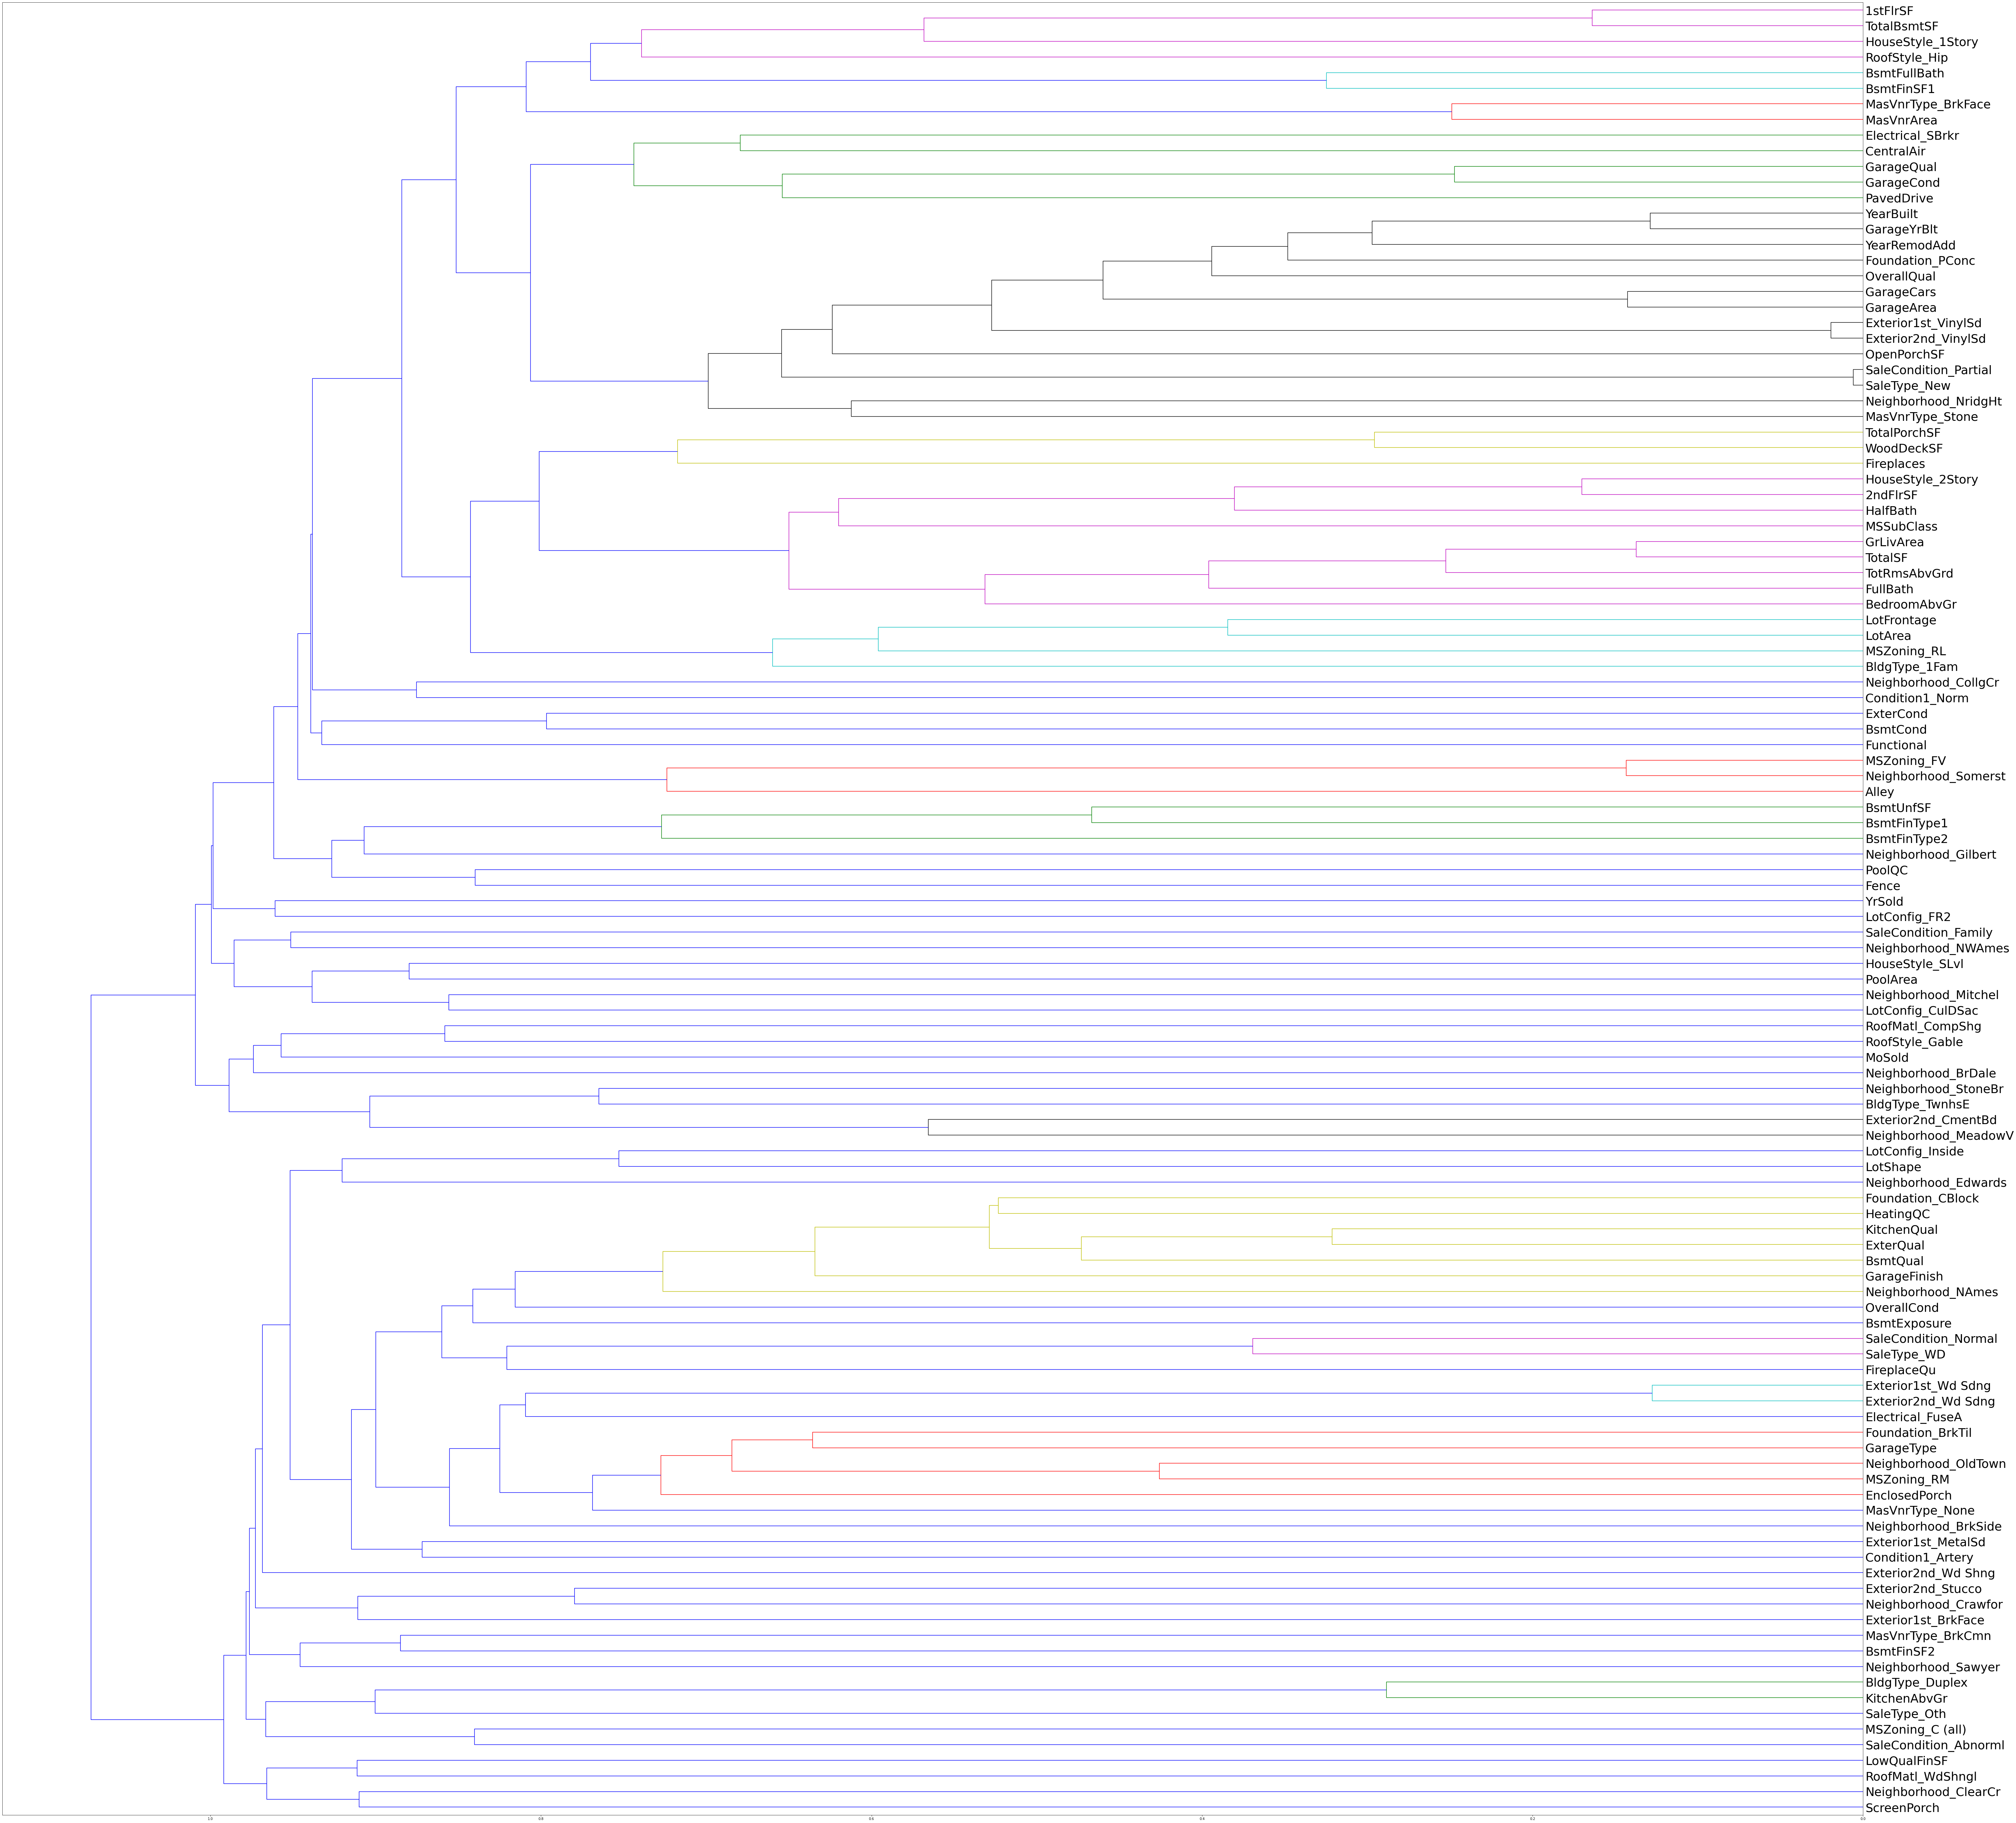

In [90]:
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(100,100))
fig.patch.set_facecolor('white')
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=36)
plt.show()

In [97]:
co_lin = ['1stFlrSF', 'TotalBsmtSF', 'MasVnrType_BrkFace', 'MasVnrArea', 'GarageQual', 'GarageCond', 'YearBuilt',
         'GarageYrBlt', 'GarageCars', 'GarageArea', 'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'SaleCondition_Partial',
         'SaleType_New', 'HouseStyle_2Story', '2ndFlrSF', 'GrLivArea', 'TotalSF', 'MSZoning_FV', 'Neighborhood_Somerst',
         'Exterior1st_Wd Sdng', 'Exterior2nd_Wd Sdng', 'KitchenAbvGr', 'BldgType_Duplex', 'TotRmsAbvGrd', "YearRemodAdd",
          'BsmtFullBath', 'BsmtFinSF1', 'Foundation_PConc', 'BsmtFinType1', 'BsmtFinType2']

We now drop these features one at a time and train a new model. If any of these models perform better than our previous model, we keep track of the dropped feature that was responsible for the improvement.

In [109]:
dic = {}

for f in co_lin:
    
    features2 = features[to_keep].drop(f, axis=1).copy()
    
    X_train, X_valid, y_train, y_valid = train_test_split(features2, labels, test_size=0.3, random_state=5)
    
    m = GradientBoostingRegressor(n_estimators=1013, learning_rate=0.0259,
                                   max_features='sqrt',
                                   min_samples_leaf=2,  
                                   loss='huber', random_state =5)
    
    m.fit(X_train, y_train)
    
    if rmsle(m.predict(X_valid), y_valid) < 0.0998963721440841:
        print(f,rmsle(m.predict(X_valid), y_valid))
        
   
    dic[f] = (rmsle(m.predict(X_valid), y_valid))

GarageQual 0.09942337955509219
Exterior1st_VinylSd 0.09972477995592581
SaleType_New 0.09979406449864382
Exterior2nd_Wd Sdng 0.09969060130929024


These 4 features when individually removed improve the model. We now try removing every column individually.

In [110]:
dic2 = {}

for f in features[to_keep].columns:
    
    features2 = features[to_keep].drop(f, axis=1).copy()
    
    X_train, X_valid, y_train, y_valid = train_test_split(features2, labels, test_size=0.3, random_state=5)
    
    m = GradientBoostingRegressor(n_estimators=1013, learning_rate=0.0259,
                                   max_features='sqrt',
                                   min_samples_leaf=2,  
                                   loss='huber', random_state =5)
    
    m.fit(X_train, y_train)
    
    if rmsle(m.predict(X_valid), y_valid) < 0.0998963721440841:
        print(f,rmsle(m.predict(X_valid), y_valid))
        
   
    dic2[f] = (rmsle(m.predict(X_valid), y_valid))

GarageQual 0.09942337955509219
SaleType_New 0.09979406449864382
Exterior1st_VinylSd 0.09972477995592581
BldgType_1Fam 0.0993625230591343
ExterCond 0.09989407859288776
Fence 0.09926651749175117
Neighborhood_Sawyer 0.09930355800240201
Condition1_Norm 0.09989444062566072
Neighborhood_Mitchel 0.09981803177424095
Exterior2nd_Wd Shng 0.09931664925152987
HouseStyle_SLvl 0.09927033211662598
Neighborhood_CollgCr 0.09971300265873242
Exterior2nd_Wd Sdng 0.09969060130929024
Exterior2nd_CmentBd 0.09910163739529351


We generate all combinations of GarageQual, Exterior1st_VinylSd, SaleType_New and Exterior2nd_Wd Sdng. We then train a model without each of these feature combinations to determine the optimum combination of features to drop.

In [116]:
import itertools

drop_features = ['GarageQual', 'Exterior1st_VinylSd', 'SaleType_New', 'Exterior2nd_Wd Sdng']
combos = []

for L in range(0, len(features)+1):
    for subset in itertools.combinations(drop_features, L):
        combos.append(subset)

In [117]:
combos.pop(0)

()

In [118]:
len(combos)

15

In [119]:
list_combos = [list(elem) for elem in combos]

In [120]:
best_score = 0.09989
for combo in list_combos:
    
    features4 = features[to_keep].drop((combo), axis=1).copy()
    
    X_train, X_valid, y_train, y_valid = train_test_split(features4, labels, test_size=0.3, random_state=42)
    
    mm = GradientBoostingRegressor(n_estimators=1013, learning_rate=0.0259,
                                   max_features='sqrt',
                                   min_samples_leaf=2,  
                                   loss='huber', random_state =5)
    
    mm.fit(X_train, y_train)
    
    if rmsle(mm.predict(X_valid), y_valid) < best_score:
        best_drop_combo = (combo,rmsle(mm.predict(X_valid), y_valid))
        best_score = rmsle(mm.predict(X_valid), y_valid)
        
best_drop_combo 

(['GarageQual'], 0.09897371419255596)

Simply dropping GarageQual yields the best model performance. We can now build our final model and make predictions on the test set.

## Final Model

In [122]:
features5 = features[to_keep].drop(['GarageQual'], axis=1).copy()
    
X_train, X_valid, y_train, y_valid = train_test_split(features5, labels, test_size=0.3, random_state=42)
    
FinalModel = GradientBoostingRegressor(n_estimators=1013, learning_rate=0.0259,
                             max_features='sqrt',
                             min_samples_leaf=2,  
                             loss='huber', random_state =5)
    
FinalModel.fit(X_train, y_train)
show_scores(FinalModel)

Training Error: 0.07152405063523219
Validation Error: 0.09897371419255596
Training Accuracy: 0.968476746220207
Validation Accuracy: 0.9354200161948857


In [124]:
FinalModel = GradientBoostingRegressor(n_estimators=1013, learning_rate=0.0259,
                             max_features='sqrt',
                             min_samples_leaf=2,  
                             loss='huber', random_state =5)
    
FinalModel.fit(features5, labels)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.0259, loss='huber',
                          max_depth=3, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1013,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=5, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [127]:
predictions = FinalModel.predict(test[features5.columns])

In [131]:
submission = pd.DataFrame()
submission["Id"] = test_raw["Id"]
submission["SalePrice"] = predictions
submission["SalePrice"] = np.expm1(final_submission["SalePrice"])

In [132]:
submission.head()

,Id,SalePrice
0,1461,126895.685416
1,1462,160803.668863
2,1463,188633.230323
3,1464,200287.740951
4,1465,188314.999868


In [133]:
submission.to_csv('submission.csv', index=False)

## Results

After submitting these predictions, the models error on the test set was revealed to be 0.12396, placing 1030/4588 (top 23%) on the competition leaderboard. This test error is substantially higher than the validation error (0.09897) which indicates we have overfit to the validation set.

We will now attempt to train a new model that generalises better. 

## Model Stacking

A powerful technique frequently used to increase test performance is to aggregate multiple models into a model stack. Predictions from each individual model are used as inputs to a second layer learning algorithm, which is then trained to optimally combine these predictions to form a new set of predictions. This greatly reduces the impact of the inherent error belonging to each individual model.  

In [134]:
lightgbm = lgb.LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=3000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
lightgbm.fit(X_train, y_train)
show_scores(lightgbm)

Training Error: 0.08405612250948741
Validation Error: 0.10646598080987184
Training Accuracy: 0.9564622943534434
Validation Accuracy: 0.9252725928259011


In [135]:
xgboost = xgb.XGBRegressor(learning_rate=0.01,n_estimators=1500,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
xgboost.fit(X_train, y_train)
show_scores(xgboost)

Training Error: 0.07017118270412996
Validation Error: 0.1057397740739521
Training Accuracy: 0.9696579844043713
Validation Accuracy: 0.9262885505240842


In [136]:
RandomForest = RandomForestRegressor(n_estimators=300, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
RandomForest.fit(X_train, y_train)
show_scores(RandomForest)

Training Error: 0.0769752169165779
Validation Error: 0.1179675080177566
Training Accuracy: 0.9634885839187401
Validation Accuracy: 0.908254873097545


In [139]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
lasso_alphas = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=lasso_alphas, random_state=42, cv=kfolds))
lasso.fit(X_train, y_train)
show_scores(lasso)

Training Error: 0.10679377237810377
Validation Error: 0.09955746745962586
Training Accuracy: 0.9297221138784354
Validation Accuracy: 0.9346559759295691


In [140]:
elastic_alphas = [0.0005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
elastic_ratio = [0.03, 0.04, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99, 1]

Elastic = elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=elastic_alphas, cv=kfolds,
                                                                  l1_ratio=elastic_ratio)) 
Elastic.fit(X_train, y_train)
show_scores(Elastic)

Training Error: 0.10655106574058815
Validation Error: 0.09978755143184317
Training Accuracy: 0.9300411872985208
Validation Accuracy: 0.9343535980969264


In [141]:
ridge_alphas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

rid = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kfolds))
rid.fit(X_train, y_train)
show_scores(rid)

Training Error: 0.10739032930221853
Validation Error: 0.1008353402008175
Training Accuracy: 0.928934767278499
Validation Accuracy: 0.9329677602431514


In [142]:
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
svr.fit(X_train, y_train)
show_scores(svr)

Training Error: 0.10423566994785223
Validation Error: 0.10437236135493762
Training Accuracy: 0.9330486160855136
Validation Accuracy: 0.9281826768788213


In [144]:
stack = StackingCVRegressor(regressors=(rid, lasso, Elastic, FinalModel, xgboost, lightgbm, svr ),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [229]:
stack_features = features5.copy()

stack_model = stack.fit(np.array(stack_features), np.array(labels))

elastic_model = Elastic.fit(stack_features, labels)

lasso_model = lasso.fit(stack_features, labels)

ridge_model = rid.fit(stack_features, labels)

gbr_model = FinalModel.fit(stack_features, labels)

xgb_model = xgboost.fit(stack_features, labels)

lgb_model = lightgbm.fit(stack_features, labels)

svr_model = svr.fit(stack_features, labels)

forrest_model = RandomForest.fit(stack_features, labels)

To allow for further optimization, we can control the degree to which each individual model influences the final predictions.  

In [230]:
def blend_models_predict(X):
    return ((0.05 * elastic_model.predict(X)) + \
            (0.05 * forrest_model.predict(X)) + \
            (0.05 * lasso_model.predict(X)) + \
            (0.05 * ridge_model.predict(X)) + \
            (0.05 * svr_model.predict(X)) + \
            (0.05 * gbr_model.predict(X)) + \
            (0.15* xgb_model.predict(X)) + \
            (0.05 * lgb_model.predict(X)) + \
            (0.5* stack_model.predict(np.array(X))))

In [231]:
def stack_error(y, y_pred):
    return np.sqrt(mean_squared_error(labels, y_pred))

In [232]:
print(stack_error(labels, blend_models_predict(stack_features)))

0.07031223948047577


In [233]:
preds = blend_models_predict(test[stack_features.columns])

In [234]:
final_submission = pd.DataFrame()
final_submission["Id"] = test_raw["Id"]
final_submission["SalePrice"] = preds
final_submission["SalePrice"] = np.expm1(final_submission["SalePrice"])

final_submission.to_csv('submission.csv', index=False)

In [235]:
final_submission.head()

,Id,SalePrice
0,1461,121555.877763
1,1462,161140.056683
2,1463,187263.990754
3,1464,193922.144839
4,1465,190555.229420


## Final Results

After submitting these predictions, the models error on the test set was revealed to be 0.11617, placing 433/4588 (top 10%) on the competition leaderboard.